In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
interval = '1d'
btc_data = pd.read_csv(f'data/btc_{interval}_data_with_ma.csv', index_col=False)
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])

In [38]:
btc_data['timestamp']

0      2017-08-17
1      2017-08-18
2      2017-08-19
3      2017-08-20
4      2017-08-21
          ...    
2612   2024-10-11
2613   2024-10-12
2614   2024-10-13
2615   2024-10-14
2616   2024-10-15
Name: timestamp, Length: 2617, dtype: datetime64[ns]

In [39]:
# ma_candidates = [10, 20, 30, 50, 60, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
# ma_candidates = [230, 240, 250, 260, 270, 280, 290, 300]
# ma_candidates = [450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560]
# ma_candidates = [1000, 1010, 1020, 1030, 1040, 1050, 1060]
ma_candidates = [x for x in range(40, 210, 10)]

In [40]:
# Function to backtest strategy and calculate cumulative profit
def backtest_and_calculate_profit(_df, ma):
    df = _df.copy(deep=True)
    df['Position'] = np.where(df['close'] > df[f'MA_{ma}'], 1, 0)  # 1 for buy, 0 for sell
    df['Signal'] = df['Position'].diff()  # Buy signal when diff > 0, sell signal when diff < 0

    # Initial values
    initial_cash = 10000  # Starting with $10,000
    btc_holding = 0
    cash = initial_cash
    purchase_price = 0
    stop_loss = 0 # No stop loss    
    
    # stop_loss = 0.995 # 0.5% loss
    # stop_loss = 0.99 # 1% loss
    # stop_loss = 0.98 # 2% loss
    # stop_loss = 0.97 # 3% loss

    base_price = df['close'].iloc[0]
    final_price = df['close'].iloc[-1]
    base_portfolio_value = ((final_price - base_price) / base_price + 1) * initial_cash
    print(f"Base portfilio value: {base_portfolio_value:,.2f} USDT")  

    for i in range(0, len(df)):
        price = df['close'].iloc[i]

        # Stop loss check: Sell if the price drops more than 1% below the purchase price
        if btc_holding > 0 and price < purchase_price * stop_loss:
            sell_price = price #* (1 - 0.01 / 100) # sell price 0.01% lower 
            cash = btc_holding * sell_price  # Sell all BTC and hold cash
            btc_holding = 0  # No BTC left after selling
            current_time = df['timestamp'].iloc[i]
            print(f"{current_time}: Stop loss triggered! Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT")

        else:
            # Buy signal
            if df['Signal'].iloc[i] == 1 or price > df[f'MA_{ma}'].iloc[i]:  # Crosses above MA
                # if price < df['MA_560'].iloc[i]: # 장기 이평 아래면 안 산다. -> 하락추세로 판단
                #     continue
                if cash > 0:
                    purchase_price = price #* (1 + 0.01 / 100) # buy price 0.01% higher
                    btc_holding = cash / purchase_price  # Buy BTC with all available cash
                    cash = 0  # No cash left after buying
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Bought BTC at {purchase_price:,.2f}, holding {btc_holding:.4f} BTC")

            # Sell signal
            elif df['Signal'].iloc[i] == -1:  # Crosses below MA
                if btc_holding > 0:
                    sell_price = price #* (1 - 0.01 / 100) # sell price 0.01% lower
                    cash = btc_holding * sell_price  # Sell all BTC and hold cash
                    btc_holding = 0  # No BTC left after selling
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT\n")
        
        # Calculate current portfolio value (cash + value of BTC)
        portfolio_value = cash + (btc_holding * price)
        # Update the portfolio value for each iteration
        df.loc[i, 'portfolio_value'] = portfolio_value

    # Drop 'Signal' and 'Position' columns
    df = df.drop(columns=['Signal', 'Position'])

    # df['portfolio_value'] = portfolio_value
    # print(f"Final value for MA {ma}: {portfolio_value:,.2f} USDT")
    return df

## Filter 2018, 2022, bull, bear

In [44]:
# Filter btc_data for the year 2018 and 2022
btc_data_2018 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2018])]
btc_data_2018 = btc_data_2018.drop(btc_data_2018[~pd.to_datetime(btc_data_2018['timestamp']).dt.year.isin([2018])].index)
btc_data_2018 = btc_data_2018.reset_index(drop=True)

btc_data_2022 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2022])]
btc_data_2022 = btc_data_2022.drop(btc_data_2022[~pd.to_datetime(btc_data_2022['timestamp']).dt.year.isin([2022])].index)
btc_data_2022 = btc_data_2022.reset_index(drop=True)

btc_data_2024 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2024])]
btc_data_2024 = btc_data_2024.drop(btc_data_2024[~pd.to_datetime(btc_data_2024['timestamp']).dt.year.isin([2024])].index)
btc_data_2024 = btc_data_2024.reset_index(drop=True)

btc_data_2021 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2021])]
btc_data_2021 = btc_data_2021.drop(btc_data_2021[~pd.to_datetime(btc_data_2021['timestamp']).dt.year.isin([2021])].index)
btc_data_2021 = btc_data_2021.reset_index(drop=True)

bull_market_df = btc_data[(btc_data['timestamp'] >= '2020-03-12') & (btc_data['timestamp'] <= '2021-04-16')]
bull_bear_market_df = btc_data[(btc_data['timestamp'] >= '2020-10-10') & (btc_data['timestamp'] <= '2021-07-20')]
bear_market_df = btc_data[(btc_data['timestamp'] >= '2021-11-10') & (btc_data['timestamp'] <= '2023-01-05')]


In [61]:
btc_data.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_540,MA_550,MA_560,MA_1000,MA_1010,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060
0,2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-17 12:00:00,4436.06,4485.39,4333.42,4352.34,174.562001,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-17 16:00:00,4352.33,4354.84,4200.74,4325.23,225.109716,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
bull_market_df.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_540,MA_550,MA_560,MA_1000,MA_1010,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060
5611,2020-03-12 00:00:00,7934.58,7966.17,7558.00,7662.73,18039.354478,7845.245,7883.1725,8187.769333,8492.6952,...,8537.910537,8513.413927,8491.586464,8372.31958,8370.713000,8376.010275,8390.993301,8406.968067,8422.609400,8439.260943
5612,2020-03-12 04:00:00,7662.11,7662.80,7342.43,7392.13,23553.309775,7807.730,7851.1135,8131.332667,8465.3364,...,8538.212444,8513.713509,8491.618304,8371.72406,8369.765960,8373.728069,8388.458049,8404.305183,8420.293514,8436.647028
5613,2020-03-12 08:00:00,7392.12,7466.00,5550.00,6067.01,65426.252839,7616.551,7751.2880,8030.599667,8410.8730,...,8536.047093,8511.700800,8489.347536,8369.80936,8367.426317,8370.111667,8384.648699,8400.361356,8416.666390,8432.747415
5614,2020-03-12 12:00:00,6064.27,6307.59,5734.69,6132.13,54565.202965,7440.308,7662.9090,7931.217000,8357.1902,...,8534.029000,8509.758800,8487.114500,8367.95025,8365.219099,8366.588225,8380.903155,8396.521442,8413.118362,8428.855142
5615,2020-03-12 16:00:00,6132.13,6229.97,5947.72,6037.45,27055.620544,7251.575,7574.5355,7836.305667,8303.5968,...,8531.777926,8507.626891,8484.767786,8365.80979,8362.900752,8363.166794,8377.027990,8392.633010,8409.456886,8424.939698


## Test {ma} MA

In [45]:
ma = 120
profit_df = backtest_and_calculate_profit(bull_market_df, ma)
portfolio_value = profit_df['portfolio_value'].iloc[-1]
print(f"Final value interval {interval} for {ma} MA: {portfolio_value:,.2f} USDT")

Base portfilio value: 127,780.83 USDT
2020-04-29 00:00:00: Bought BTC at 8,778.57, holding 1.1391 BTC
2020-09-23 00:00:00: Sold BTC at 10,241.46, now holding 11,666.43 USDT

2020-09-24 00:00:00: Bought BTC at 10,736.32, holding 1.0866 BTC
Final value interval 1d for 120 MA: 66,648.38 USDT


## Test all ma candidates

In [34]:
portfolio_value_by_ma = {}
for ma in ma_candidates:
    profit_df = backtest_and_calculate_profit(btc_data_2024, ma)
    portfolio_value_by_ma[ma] = profit_df['portfolio_value'].iloc[-1]


Base portfilio value: 15,293.03 USDT
2024-01-01 00:00:00: Bought BTC at 44,179.55, holding 0.2263 BTC
2024-01-12 00:00:00: Sold BTC at 42,782.73, now holding 9,683.83 USDT

2024-01-29 00:00:00: Bought BTC at 43,302.70, holding 0.2236 BTC
2024-01-31 00:00:00: Sold BTC at 42,580.00, now holding 9,522.21 USDT

2024-02-01 00:00:00: Bought BTC at 43,082.94, holding 0.2210 BTC
2024-02-04 00:00:00: Sold BTC at 42,582.88, now holding 9,411.69 USDT

2024-02-06 00:00:00: Bought BTC at 43,098.95, holding 0.2184 BTC
2024-04-02 00:00:00: Sold BTC at 65,463.99, now holding 14,295.63 USDT

2024-04-03 00:00:00: Bought BTC at 65,963.28, holding 0.2167 BTC
2024-04-12 00:00:00: Sold BTC at 67,116.52, now holding 14,545.56 USDT

2024-05-15 00:00:00: Bought BTC at 66,206.50, holding 0.2197 BTC
2024-06-13 00:00:00: Sold BTC at 66,773.01, now holding 14,670.03 USDT

2024-07-15 00:00:00: Bought BTC at 64,724.14, holding 0.2267 BTC
2024-08-02 00:00:00: Sold BTC at 61,498.33, now holding 13,938.88 USDT

2024-08

In [35]:
print (f"interval: {interval}")

for ma, value in portfolio_value_by_ma.items():
    print(f"Final value for MA {ma}: {value:,.2f} USDT") 

# Find the MA with the highest portfolio value
best_ma = max(portfolio_value_by_ma, key=portfolio_value_by_ma.get)
best_value = portfolio_value_by_ma[best_ma]

print(f"The best performing for {interval} is {best_ma} MA with a final portfolio value of {best_value:,.2f} USDT")


interval: 1d
Final value for MA 40: 13,446.96 USDT
Final value for MA 50: 12,439.66 USDT
Final value for MA 60: 10,685.95 USDT
Final value for MA 70: 11,560.63 USDT
Final value for MA 80: 10,735.82 USDT
Final value for MA 90: 11,559.20 USDT
Final value for MA 100: 11,607.47 USDT
Final value for MA 110: 13,554.18 USDT
Final value for MA 120: 13,459.45 USDT
Final value for MA 130: 13,434.48 USDT
Final value for MA 140: 13,153.66 USDT
Final value for MA 150: 13,527.94 USDT
Final value for MA 160: 12,131.30 USDT
Final value for MA 170: 13,164.27 USDT
Final value for MA 180: 11,979.85 USDT
Final value for MA 190: 12,445.73 USDT
Final value for MA 200: 12,681.92 USDT
The best performing for 1d is 110 MA with a final portfolio value of 13,554.18 USDT


## Just holding BTC

In [25]:
# Function to calculate final value of holding BTC
def calculate_holding_value(df):
    initial_cash = 10000  # Start with $10,000 in cash

    # Buy BTC at the first available price
    initial_price = df['close'].iloc[0]
    btc_holding = initial_cash / initial_price  # Buy BTC with all available cash

    # Sell BTC at the last available price
    final_price = df['close'].iloc[-1]
    final_value = btc_holding * final_price  # Calculate the value of the BTC holding

    print(f"Initial BTC price: {initial_price:.2f} USDT")
    print(f"Final BTC price: {final_price:.2f} USDT")
    print(f"Final value of holding BTC: {final_value:,.2f} USDT")
    
    return final_value

In [26]:

# Example usage
# Assuming 'df' is a DataFrame with your historical price data (e.g., 1-hour BTC/USDT prices)
final_value = calculate_holding_value(btc_data)
just_holding_btc = final_value

Initial BTC price: 4349.99 USDT
Final BTC price: 67571.80 USDT
Final value of holding BTC: 155,337.83 USDT


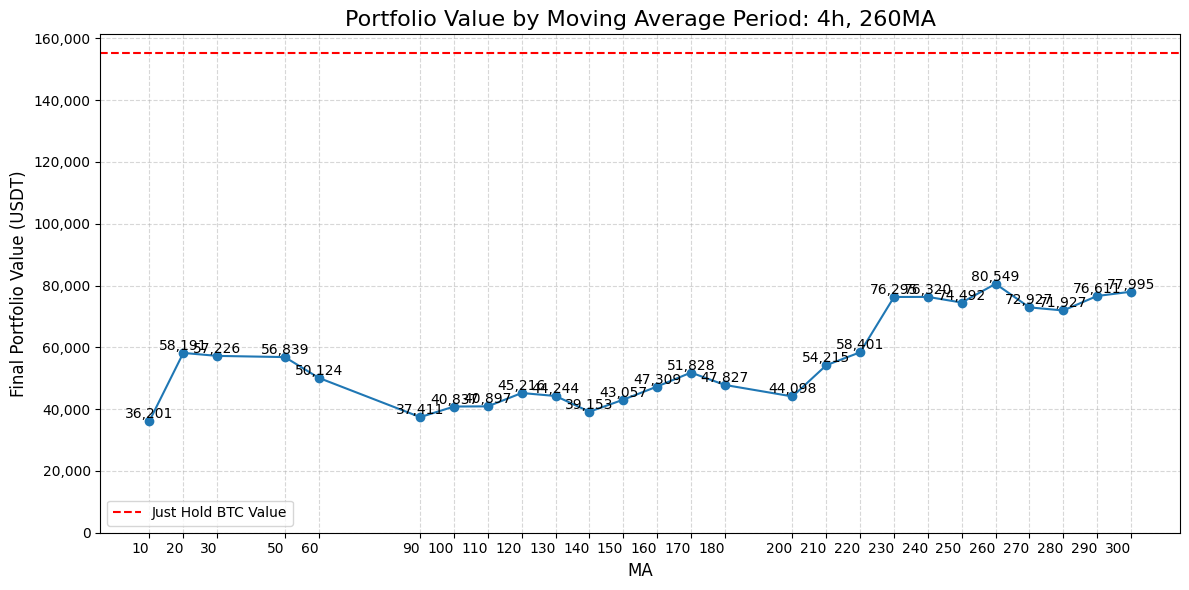

In [27]:
import matplotlib.ticker as ticker

# Sort the dictionary by MA values
sorted_portfolio_value = dict(sorted(portfolio_value_by_ma.items()))

# Extract MA values and corresponding portfolio values
ma_values = list(sorted_portfolio_value.keys())
portfolio_values = list(sorted_portfolio_value.values())

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(ma_values, portfolio_values, marker='o')

# Customize the plot
plt.title(f'Portfolio Value by Moving Average Period: {interval}, {best_ma}MA', fontsize=16)
plt.xlabel('MA', fontsize=12)
plt.ylabel('Final Portfolio Value (USDT)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas


# Add value labels on top of each point
for i, value in enumerate(portfolio_values):
    plt.text(ma_values[i], value, f'{value:,.0f}', ha='center', va='bottom')

# Add x-axis labels for each MA value
plt.xticks(ma_values, [f'{ma}' for ma in ma_values], rotation=0, ha='right')

# Adjust the bottom margin to accommodate the labels
plt.subplots_adjust(bottom=0.2)

# Add a horizontal line at just_holding_btc
plt.axhline(y=just_holding_btc, color='red', linestyle='--', label='Just Hold BTC Value')
plt.legend()

# Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()


## Portfolio cumulative profit

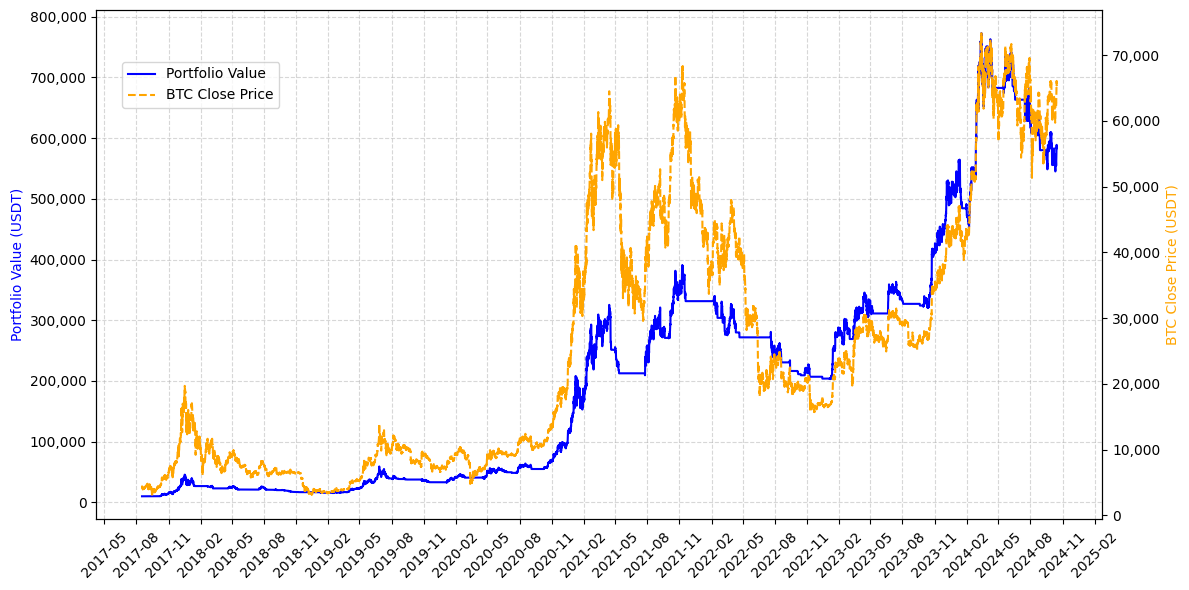

In [30]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime

# Create a new figure with a specific size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the portfolio value over time on the left y-axis
ax1.plot(btc_data['timestamp'], btc_data['portfolio_value'], label='Portfolio Value', color='blue')

# Set x-axis ticks to show every 3 months
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Tick every 3 months

# Format the x-axis to show Year-Month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate the x-ticks for readability
plt.xticks(rotation=45)

# Set the y-axis label for portfolio value
ax1.set_ylabel('Portfolio Value (USDT)', color='blue')

# Format y-axis tick labels with commas on the left axis
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

# Enable grid for left axis
ax1.grid(True, linestyle='--', alpha=0.5)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the BTC close price on the right y-axis
ax2.plot(btc_data['timestamp'], btc_data['close'], label='BTC Close Price', color='orange', linestyle='--')

# Set the y-axis label for BTC close price
ax2.set_ylabel('BTC Close Price (USDT)', color='orange')

# Optionally, format the y-axis on the right if needed (e.g., formatting for currency)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

# Add a legend for both plots
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Adjust layout to prevent cutting off labels
fig.tight_layout()

# Show the plot
plt.show()

In [31]:
# Filter btc_data for the year 2018 and 2022
btc_data_2018 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2017, 2018])]
btc_data_2018 = btc_data_2018.drop(btc_data_2018[~pd.to_datetime(btc_data_2018['timestamp']).dt.year.isin([2017, 2018])].index)
btc_data_2018 = btc_data_2018.reset_index(drop=True)

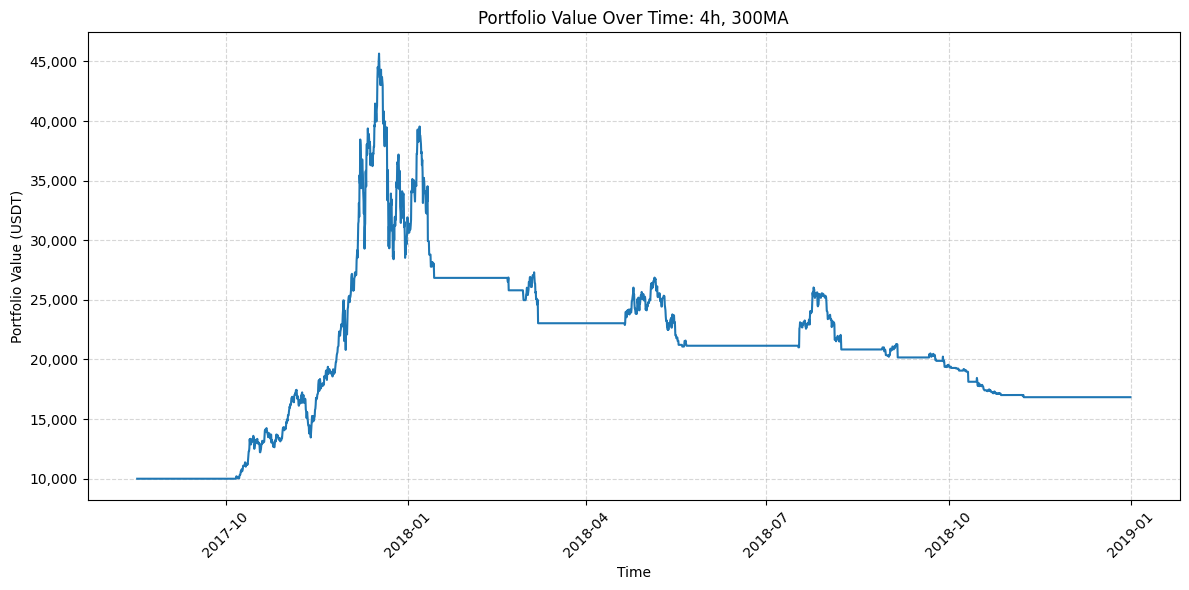

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime

# Create a new figure with a specific size
plt.figure(figsize=(12, 6))

# Plot the portfolio value over time
plt.plot(btc_data_2018['timestamp'], btc_data_2018['portfolio_value'], label='Portfolio Value')
plt.gca().autoscale()

# Set x-axis limits to show only 2017
# start_date = datetime(2017, 1, 1)
# end_date = datetime(2017, 12, 31)
# plt.xlim(start_date, end_date)

# Set x-axis ticks to show every 3 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Tick every 3 months

# Format the x-axis to show Year-Month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate the x-ticks for readability
plt.xticks(rotation=45)

# Set y-axis limits
# plt.ylim(-100000, 1300000)

# Set y-axis ticks to every 100,000 units
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100000))  # Tick every 100k

# Format y-axis tick labels with commas
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas
# Set labels and title
plt.xlabel('Time')
plt.ylabel('Portfolio Value (USDT)')
plt.title(f'Portfolio Value Over Time: {interval}, {ma}MA')

# Enable grid with a dashed line style
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()